In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc
import optuna
import time

In [2]:
clinvar_anno = pd.read_csv("./2024_GESW_ML/clinvar_20240730_chr1_gene_dbNSFP.hg38_multianno.txt",sep='\t')

In [3]:
clinvar_anno

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,SiPhy_29way_logOdds_rankscore,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,Otherinfo1
0,1,69134,69134,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A44G:p.E15G,...,0.32369,994,0.00715,.;.,.,.,.,.,.,Likely_benign
1,1,69314,69314,T,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T224G:p.I75S,...,0.17765,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
2,1,69423,69423,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G333A:p.M111I,...,0.45461,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
3,1,69581,69581,C,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.C491G:p.P164R,...,0.45461,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
4,1,69682,69682,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G592A:p.V198M,...,0.25151,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256277,1,248917999,248917999,A,G,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.A662G:p.K221R,PGBD2...",...,0.13208,.,.,PiggyBac transposable element-derived protein;...,.,.,.,.,.,Uncertain_significance
256278,1,248918022,248918022,A,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.A685T:p.M229L,PGBD2...",...,0.34381,.,.,PiggyBac transposable element-derived protein;...,.,.,.,.,.,Uncertain_significance
256279,1,248918194,248918194,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G857A:p.R286Q,PGBD2...",...,0.20419,.,.,.;.,.,.,.,.,.,Uncertain_significance
256280,1,248918214,248918214,G,C,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G877C:p.E293Q,PGBD2...",...,0.42193,.,.,.;.,.,.,.,.,.,Uncertain_significance


In [5]:
clinvar_anno_missense = clinvar_anno[clinvar_anno['ExonicFunc.refGene'] == 'nonsynonymous SNV']

In [6]:
clinvar_anno_missense

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,SiPhy_29way_logOdds_rankscore,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,Otherinfo1
0,1,69134,69134,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A44G:p.E15G,...,0.32369,994,0.00715,.;.,.,.,.,.,.,Likely_benign
1,1,69314,69314,T,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T224G:p.I75S,...,0.17765,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
2,1,69423,69423,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G333A:p.M111I,...,0.45461,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
3,1,69581,69581,C,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.C491G:p.P164R,...,0.45461,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
4,1,69682,69682,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G592A:p.V198M,...,0.25151,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256277,1,248917999,248917999,A,G,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.A662G:p.K221R,PGBD2...",...,0.13208,.,.,PiggyBac transposable element-derived protein;...,.,.,.,.,.,Uncertain_significance
256278,1,248918022,248918022,A,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.A685T:p.M229L,PGBD2...",...,0.34381,.,.,PiggyBac transposable element-derived protein;...,.,.,.,.,.,Uncertain_significance
256279,1,248918194,248918194,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G857A:p.R286Q,PGBD2...",...,0.20419,.,.,.;.,.,.,.,.,.,Uncertain_significance
256280,1,248918214,248918214,G,C,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G877C:p.E293Q,PGBD2...",...,0.42193,.,.,.;.,.,.,.,.,.,Uncertain_significance


In [13]:
clinvar_anno_missense_6classees = clinvar_anno_missense[clinvar_anno_missense['Otherinfo1'].isin(["Likely_benign","Benign","Likely_pathogenic","Pathogenic","Uncertain_significance"])]

In [14]:
clinvar_anno_missense_6classees

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,SiPhy_29way_logOdds_rankscore,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,Otherinfo1
0,1,69134,69134,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A44G:p.E15G,...,0.32369,994,0.00715,.;.,.,.,.,.,.,Likely_benign
1,1,69314,69314,T,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T224G:p.I75S,...,0.17765,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
2,1,69423,69423,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G333A:p.M111I,...,0.45461,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
3,1,69581,69581,C,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.C491G:p.P164R,...,0.45461,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
4,1,69682,69682,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G592A:p.V198M,...,0.25151,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Uncertain_significance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256277,1,248917999,248917999,A,G,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.A662G:p.K221R,PGBD2...",...,0.13208,.,.,PiggyBac transposable element-derived protein;...,.,.,.,.,.,Uncertain_significance
256278,1,248918022,248918022,A,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.A685T:p.M229L,PGBD2...",...,0.34381,.,.,PiggyBac transposable element-derived protein;...,.,.,.,.,.,Uncertain_significance
256279,1,248918194,248918194,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G857A:p.R286Q,PGBD2...",...,0.20419,.,.,.;.,.,.,.,.,.,Uncertain_significance
256280,1,248918214,248918214,G,C,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G877C:p.E293Q,PGBD2...",...,0.42193,.,.,.;.,.,.,.,.,.,Uncertain_significance


/tmp/ipykernel_595/4222790189.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


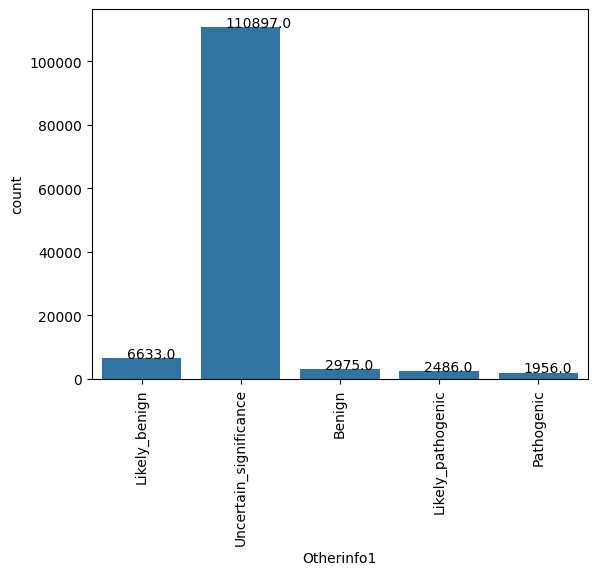

In [16]:
plt.clf()
ax = sns.countplot(x='Otherinfo1', data=clinvar_anno_missense_6classees)

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
plt.show()

In [17]:
clinvar_anno_missense_b_p  = clinvar_anno_missense[clinvar_anno_missense['Otherinfo1'].isin(['Benign','Pathogenic'])]

In [18]:
clinvar_anno_missense_b_p

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,SiPhy_29way_logOdds_rankscore,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,Otherinfo1
32,1,930165,930165,G,A,exonic,SAMD11,.,nonsynonymous SNV,"SAMD11:NM_001385640:exon3:c.G620A:p.R207Q,SAMD...",...,0.84127,940,0.13648,.;.;.;.;.;.;.;.;.;.;.,.,.,.,.,.,Benign
43,1,930204,930204,G,A,exonic,SAMD11,.,nonsynonymous SNV,"SAMD11:NM_001385640:exon3:c.G659A:p.R220Q,SAMD...",...,0.86010,940,0.13648,.;.;.;.;.;.;.;.;.;.;.,.,.,.,.,.,Benign
73,1,930285,930285,G,A,exonic,SAMD11,.,nonsynonymous SNV,"SAMD11:NM_001385640:exon3:c.G740A:p.R247Q,SAMD...",...,0.26537,940,0.13648,.;.;.;.;.;.;.;.;.;.;.,.,.,.,.,.,Benign
78,1,930314,930314,C,T,exonic,SAMD11,.,nonsynonymous SNV,"SAMD11:NM_001385640:exon3:c.C769T:p.H257Y,SAMD...",...,0.86420,940,0.13648,.;.;.;.;.;.;.;.;.;.;.,.,.,.,.,.,Benign
281,1,939429,939429,G,C,exonic,SAMD11,.,nonsynonymous SNV,SAMD11:NM_152486:exon7:c.G675C:p.W225C,...,0.13079,940,0.13648,.;.;.,.,.,.,.,.,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255720,1,248180689,248180689,G,A,exonic,OR2M2,.,nonsynonymous SNV,OR2M2:NM_001004688:exon1:c.G704A:p.C235Y,...,0.19535,976,0.04745,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",LYPD8,Colon_Transverse,.,.,.,Benign
255789,1,248273336,248273336,A,G,exonic,OR2T33,.,nonsynonymous SNV,OR2T33:NM_001004695:exon1:c.T479C:p.V160A,...,0.17770,982,0.03397,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Benign
255943,1,248453107,248453107,C,T,exonic,OR2T2,.,nonsynonymous SNV,OR2T2:NM_001004136:exon1:c.C310T:p.L104F,...,0.30282,982,0.03397,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Benign
255944,1,248453117,248453117,C,A,exonic,OR2T2,.,nonsynonymous SNV,OR2T2:NM_001004136:exon1:c.C320A:p.T107N,...,0.16203,982,0.03397,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,Benign


In [20]:
TP = len(clinvar_anno_missense[(clinvar_anno_missense['MetaSVM_pred'] == 'D') & (clinvar_anno_missense['Otherinfo1'] == 'Pathogenic')])
TN = len(clinvar_anno_missense[(clinvar_anno_missense['MetaSVM_pred'] == 'T') & (clinvar_anno_missense['Otherinfo1'] == 'Benign')])
FP = len(clinvar_anno_missense[(clinvar_anno_missense['MetaSVM_pred'] == 'D') & (clinvar_anno_missense['Otherinfo1'] == 'Benign')])
FN = len(clinvar_anno_missense[(clinvar_anno_missense['MetaSVM_pred'] == 'T') & (clinvar_anno_missense['Otherinfo1'] == 'Pathogenic')])

# Calculate the metrics
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
ppv = TP / (TP + FP) if (TP + FP) > 0 else 0

# Display the results
metrics = {
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Accuracy': accuracy,
    'PPV': ppv
}

metrics

{'Sensitivity': 0.791967044284243,
 'Specificity': 0.9130583020797818,
 'Accuracy': 0.8648205128205129,
 'PPV': 0.8577802565532627}

In [24]:
#MetaSVM_score, MetaLR_score, CADD_raw, VEST4_score, REVEL_score
clinvar_anno_missense_b_p_5methods = clinvar_anno_missense_b_p[['MetaSVM_score','MetaLR_score','CADD_raw','VEST4_score','REVEL_score','Otherinfo1']]

In [25]:
clinvar_anno_missense_b_p_5methods

,MetaSVM_score,MetaLR_score,CADD_raw,VEST4_score,REVEL_score,Otherinfo1
32,-0.6569,0.171,5.525143,0.612,0.257,Benign
43,-0.7940,0.058,2.912965,0.26,0.208,Benign
73,-1.0382,0.061,0.279046,0.17,0.022,Benign
78,-1.0840,0.001,2.850487,0.329,0.103,Benign
281,-1.0338,0.023,0.126376,0.337,0.088,Benign
...,...,...,...,...,...,...
255720,-1.0548,0.000,-0.364075,0.041,0.050,Benign
255789,-1.0285,0.000,-0.281976,0.056,0.017,Benign
255943,-1.0175,0.001,1.322232,0.059,0.014,Benign
255944,-0.9628,0.001,3.092159,0.158,0.084,Benign


In [26]:
# Replace '.' with NaN
clinvar_anno_missense_b_p_5methods.replace('.', np.nan, inplace=True)

/tmp/ipykernel_595/2143350215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_anno_missense_b_p_5methods.replace('.', np.nan, inplace=True)


In [27]:
clinvar_anno_missense_b_p_5methods_cleaned = clinvar_anno_missense_b_p_5methods.dropna()

In [28]:
clinvar_anno_missense_b_p_5methods_cleaned

,MetaSVM_score,MetaLR_score,CADD_raw,VEST4_score,REVEL_score,Otherinfo1
32,-0.6569,0.171,5.525143,0.612,0.257,Benign
43,-0.7940,0.058,2.912965,0.26,0.208,Benign
73,-1.0382,0.061,0.279046,0.17,0.022,Benign
78,-1.0840,0.001,2.850487,0.329,0.103,Benign
281,-1.0338,0.023,0.126376,0.337,0.088,Benign
...,...,...,...,...,...,...
255719,-1.0200,0.000,-0.423414,0.009,0.020,Benign
255720,-1.0548,0.000,-0.364075,0.041,0.050,Benign
255789,-1.0285,0.000,-0.281976,0.056,0.017,Benign
255943,-1.0175,0.001,1.322232,0.059,0.014,Benign


In [29]:
X = clinvar_anno_missense_b_p_5methods_cleaned.drop(columns=['Otherinfo1'])
y = clinvar_anno_missense_b_p_5methods_cleaned['Otherinfo1']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
# Display the ratio of classes in the original, training, and test sets
print("Original class distribution:")
print(y.value_counts(normalize=True))

print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Original class distribution:
Otherinfo1
Benign        0.599211
Pathogenic    0.400789
Name: proportion, dtype: float64

Training set class distribution:
Otherinfo1
Benign        0.599118
Pathogenic    0.400882
Name: proportion, dtype: float64

Test set class distribution:
Otherinfo1
Benign        0.599585
Pathogenic    0.400415
Name: proportion, dtype: float64


In [31]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    # Initialize the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model using cross-validation
    accuracy = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy').mean()
    
    return accuracy

In [33]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Display the best hyperparameters
print(f'Best hyperparameters: {study.best_params}')

[I 2024-08-10 22:47:31,011] A new study created in memory with name: no-name-d1176281-fa2b-4ddc-baee-2dece46a9fc8
[I 2024-08-10 22:47:54,101] Trial 0 finished with value: 0.9151483749411209 and parameters: {'n_estimators': 226, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9151483749411209.
[I 2024-08-10 22:48:25,035] Trial 1 finished with value: 0.9141100868043871 and parameters: {'n_estimators': 333, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9151483749411209.
[I 2024-08-10 22:49:53,610] Trial 2 finished with value: 0.9156692012650561 and parameters: {'n_estimators': 881, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9156692012650561.
[I 2024-08-10 22:50:32,495] Trial 3 finished with value: 0.9151470291366663 and parameters: {'n_estimators': 429, 'max_depth': 12, 'm

Best hyperparameters: {'n_estimators': 218, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt'}


In [34]:
#Train the Final Model
# Retrieve the best hyperparameters
best_params = study.best_params

# Initialize the Random Forest model with the best hyperparameters
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

# Train the model on the entire training set
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=9, min_samples_split=8,
                       n_estimators=218, random_state=42)

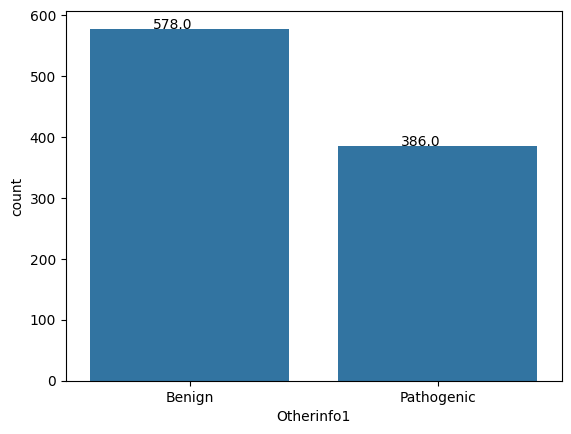

In [36]:
plt.clf()
ax = sns.countplot(x='Otherinfo1', data=pd.DataFrame(y_test))

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    
plt.show()

In [37]:
pd.DataFrame(y_test)

,Otherinfo1
221028,Benign
30207,Pathogenic
206488,Benign
164977,Benign
109091,Pathogenic
...,...
251281,Benign
220329,Benign
147961,Pathogenic
63625,Benign


In [38]:
#Evaluate the Model
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9304979253112033
Confusion Matrix:
[[551  27]
 [ 40 346]]
Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.95      0.94       578
  Pathogenic       0.93      0.90      0.91       386

    accuracy                           0.93       964
   macro avg       0.93      0.92      0.93       964
weighted avg       0.93      0.93      0.93       964



In [39]:
TP = 346
TN = 550
FP = 28
FN = 40
# Calculate the metrics
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
ppv = TP / (TP + FP) if (TP + FP) > 0 else 0

# Calculate F1-score
f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

# Display the results
metrics = {
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Accuracy': accuracy,
    'PPV': ppv,
    'F1-score': f1_score
}

metrics

{'Sensitivity': 0.8963730569948186,
 'Specificity': 0.9515570934256056,
 'Accuracy': 0.9294605809128631,
 'PPV': 0.9251336898395722,
 'F1-score': 0.9105263157894736}

In [41]:
# Make probability predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]  # Assuming binary classification and extracting the probability for class 1

In [45]:
# Calculate AUROC
auroc = roc_auc_score(y_test, y_prob)
print(f'AUROC: {auroc}')

AUROC: 0.9694049518618786


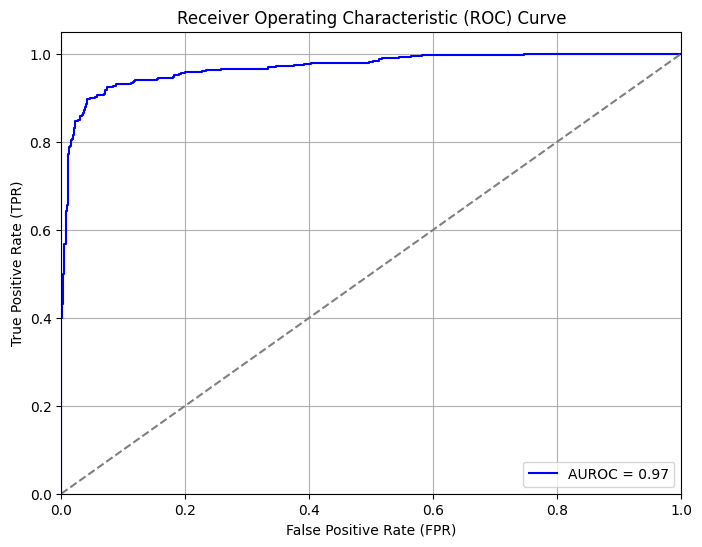

In [48]:
# Convert categorical labels to binary (0 and 1)
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [55]:
feature_names = X_test.columns.tolist()
start_time = time.time()
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 2.371 seconds


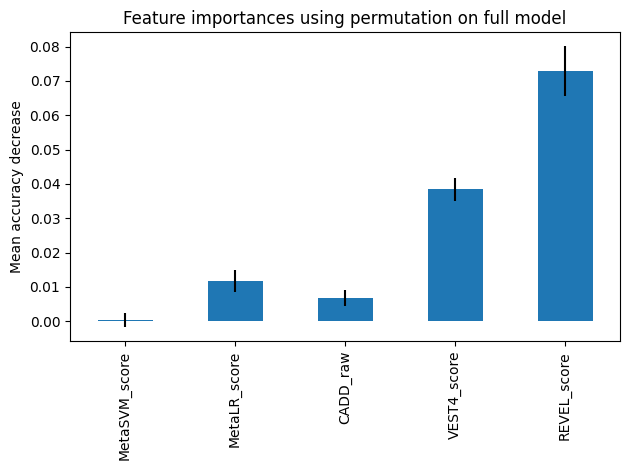

In [56]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()